In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import json

# Model

In [2]:
tank_size = np.array([111,142]) # actual size: 114cm x 89cm but it is scaled by a walking speed of 0.8 cm/s
# tank_size = np.array([28,36])
walking_speed = 1 # unit/s
swimming_speed = 8 # unit/s

env_shape = (tank_size * 2) + 1

In [3]:
walking_moves = [
    np.array([1 , 0]),
    np.array([0 , 1]),
    np.array([-1, 0]),
    np.array([0 ,-1]),
]

In [4]:
# Moves
rad = 8.5
center = np.array([0,0])
moves = []

for r in [0,4]:
# for r in range(int(np.floor(rad * np.sqrt(0.5)))):
    d = int(np.floor(np.sqrt(rad**2 - r**2)))
    moves.append(center + np.array([-d,  r]))
    moves.append(center + np.array([ d,  r]))
    moves.append(center + np.array([-d, -r]))
    moves.append(center + np.array([ d, -r]))
    moves.append(center + np.array([ r, -d]))
    moves.append(center + np.array([ r,  d]))
    moves.append(center + np.array([-r, -d]))
    moves.append(center + np.array([-r,  d]))

u_moves = list({m.tobytes():m for m in moves}.values())

In [5]:
all_moves = walking_moves + u_moves

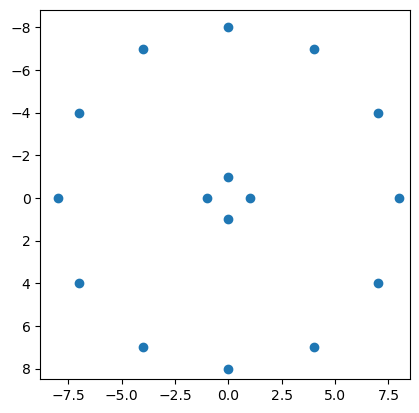

In [6]:
# Swimming steps
plt.imshow(np.zeros((9,9)), cmap='Greys')
plt.scatter(np.array(all_moves)[:,0], np.array(all_moves)[:,1])

In [7]:
### definition of likelihood, likelihood is defined in the state space
source_radius = 10.5 # 8cm in tank but it is scaled by a walking speed of 0.8 cm/s
source_position = tank_size

like = np.fromfunction(lambda x,y: ((x - source_position[0])**2 + (y - source_position[1])**2) <= source_radius**2, shape=env_shape).astype(float)

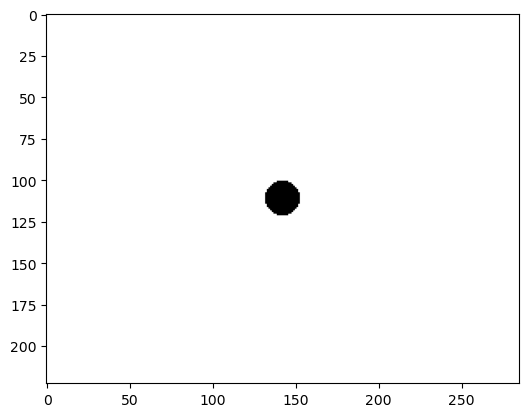

In [8]:
plt.imshow(like, cmap='Greys')

In [9]:
### POMDP states definition
state_grid = []  # this is a list of My lists of Mx strings (state labels) each
# State labels
for i in range(env_shape[0]): # My
    i_states = []
    for j in range(env_shape[1]): # Mx
        i_states.append(f's_{i}_{j}') # s_yind_xind
    state_grid.append(i_states)
state_count = int(np.prod(env_shape))

In [10]:
reachable_states = np.full(shape=(state_count, len(all_moves)), fill_value=-1)

for x in range(env_shape[0]):
    for y in range(env_shape[1]):
        for a, m in enumerate(all_moves):
            pos = np.array([x,y])
            m = np.array(m)

            new_pos = pos + m

            # Handle border for new pos
            new_pos = new_pos % np.array(env_shape)
            new_pos[0] = new_pos[0] + env_shape[0] if new_pos[0] < 0 else new_pos[0]
            new_pos[1] = new_pos[1] + env_shape[1] if new_pos[1] < 0 else new_pos[1]

            # Flatten pos
            flat_pos = (env_shape[1] * pos[0]) + pos[1]
            flat_new_pos = (env_shape[1] * new_pos[0]) + new_pos[1]
            reachable_states[flat_pos, a] = flat_new_pos

reachable_states = reachable_states[:,:,None]

In [11]:
# flatten mette di default tutte le righe una in fila all'altra shape = (shape[0]*shape[1],), [:,None] rende questo vettore riga un matrice con una colonna shape = (shape[0]*shape[1],1)
observation_walking = np.concatenate((like.flatten()[:,None], (1-like.flatten()[:,None])),axis=1)
# shape is (like.shape[0]*like.shape[1],2)
observation_swimming = np.concatenate((np.zeros(state_count)[:,None], np.ones(state_count)[:,None]),axis=1)
# observation shape = (number of states,n actions, n observation values)

observations = np.hstack([observation_walking[:,None,:].repeat(4,axis=1), observation_swimming[:,None,:].repeat(len(all_moves)-4, axis=1)])

In [12]:
model = Model(
    states=state_grid,
    actions=all_moves,
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    observation_table=observations,
    end_states=[(env_shape[1]*(env_shape[0]-1)/2 + (env_shape[1]-1)/2)]
    )

[04/16/2024, 16:45:43] Instantiation of MDP Model:
[04/16/2024, 16:45:43] - 63555 states
[04/16/2024, 16:45:43] - 16 actions
[04/16/2024, 16:45:43] - At most 1 reachable states per state-action pair
[04/16/2024, 16:45:43] - Starting generation of transitions table
[04/16/2024, 16:45:43]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[04/16/2024, 16:45:43]     > Done in 0.000s
[04/16/2024, 16:45:43] - Generation of state grid
[04/16/2024, 16:45:43] - Generating start probabilities table
[04/16/2024, 16:45:43] - Starting computation of reachable state probabilities from transition data
[04/16/2024, 16:45:43]     > Done in 0.001s

[04/16/2024, 16:45:43] POMDP particular parameters:
[04/16/2024, 16:45:43] - 2 observations
[04/16/2024, 16:45:43] - Starting of transitional observations for reachable states table
[04/16/2024, 16:45:44]     > Done in 0.044s
[04/16/

# MDP Solution

In [13]:
mdp_model = Model(
    states=state_grid,
    actions=all_moves[:4],
    observations=['something', 'nothing'],
    reachable_states=reachable_states[:,:4,:],
    observation_table=observations[:,:4,:],
    end_states=[(env_shape[1]*(env_shape[0]-1)/2 + (env_shape[1]-1)/2)]
    )

[04/16/2024, 16:45:44] Instantiation of MDP Model:
[04/16/2024, 16:45:44] - 63555 states
[04/16/2024, 16:45:44] - 4 actions
[04/16/2024, 16:45:44] - At most 1 reachable states per state-action pair
[04/16/2024, 16:45:44] - Starting generation of transitions table
[04/16/2024, 16:45:44]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[04/16/2024, 16:45:44]     > Done in 0.000s
[04/16/2024, 16:45:44] - Generation of state grid
[04/16/2024, 16:45:44] - Generating start probabilities table
[04/16/2024, 16:45:44] - Starting computation of reachable state probabilities from transition data
[04/16/2024, 16:45:44]     > Done in 0.001s

[04/16/2024, 16:45:44] POMDP particular parameters:
[04/16/2024, 16:45:44] - 2 observations
[04/16/2024, 16:45:44] - Starting of transitional observations for reachable states table
[04/16/2024, 16:45:44]     > Done in 0.008s
[04/16/2

In [14]:
from src.mdp import VI_Solver

solver = VI_Solver(eps=1e-3)
# solution, history = solver.solve(model, use_gpu=True)
solution, history = solver.solve(mdp_model, use_gpu=True)

[04/16/2024, 16:45:44] Sending Model to GPU...
[04/16/2024, 16:45:44]     > Done in 0.428s


  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
# solution.plot()

# FSVI Training

In [16]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-8, mdp_policy=solution)

fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        max_belief_growth=100,
                                        expansions=800,
                                        print_progress=True,
                                        # expand_prune_level=2,
                                        use_gpu=True)
                                    
print(hist.summary)

[04/16/2024, 16:45:45] Sending Model to GPU...
[04/16/2024, 16:45:45]     > Done in 0.019s


Expansions:   0%|          | 0/800 [00:00<?, ?it/s]

Memory full: Out of memory allocating 22,192,389,120 bytes (allocated so far: 62,161,421,312 bytes).
Returning value function and history as is...

Summary of Value Iteration run
  - Model: 63555 state, 16 action, 2 observations
  - Converged or stopped after 138 expansion steps and 137 backup steps.
  - Resulting value function has 1364 alpha vectors.
  - Converged in 112.6656s

  - Expand function took on average 0.0725s and yielded on average 2232.28 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.7493s and yielded on average 9.84 alpha vectors per iteration. (0.0012s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


In [17]:
fsvi_solution.save_parquet(path='./', file_name='sea_robins_walk_swim_105rad')

# Test

Source [ 52 116]
Agent [89 51]


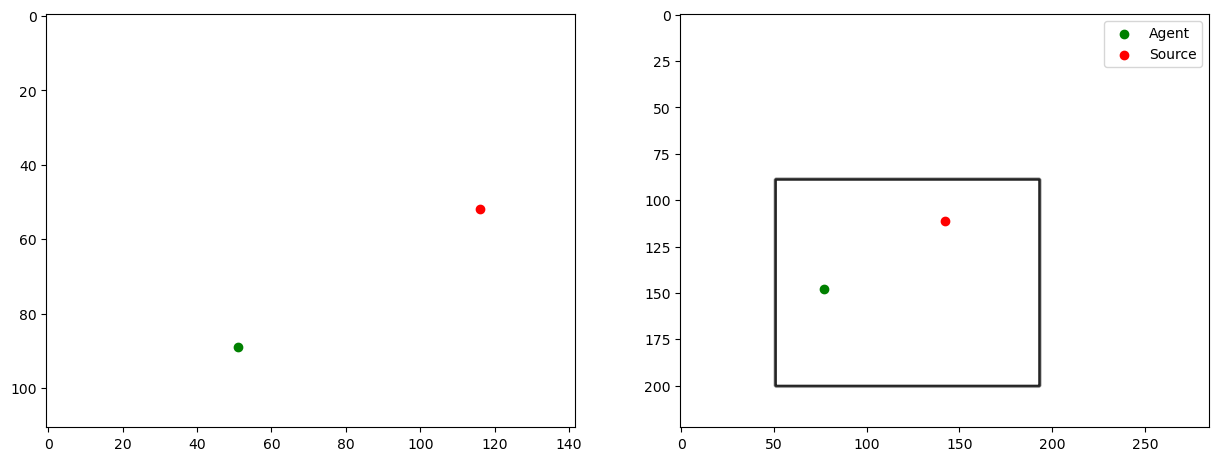

In [18]:
# PHYSICAL SPACE
# source_point = (np.random.random(2) * tank_size).astype(int)
# agent_start = (np.random.random(2) * tank_size).astype(int)

source_point = np.array([52, 116])
agent_start = np.array([89, 51])

print(f'Source {source_point}')
print(f'Agent {agent_start}')

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,10))

ax0.imshow(np.zeros(tank_size), cmap='Greys')
ax0.scatter(source_point[1], source_point[0], c='red', label='Source')
ax0.scatter(agent_start[1], agent_start[0], c='green', label='Agent')

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size - source_point)

belief = np.zeros(env_shape)
belief[center_state[0]:center_state[0]+tank_size[0]+1, center_state[1]:center_state[1]+tank_size[1]+1] = 1
belief /= np.sum(belief)

ax1.imshow(np.zeros(env_shape), cmap='Greys')
ax1.contour(belief, cmap='Greys')
# ax1.invert_yaxis()
ax1.scatter(agent_start_state[1], agent_start_state[0], c='green', label='Agent')
ax1.scatter(tank_size[1], tank_size[0], c='red', label='Source')
ax1.legend()

In [65]:
# Load fsvi
# fsvi_solution = ValueFunction.load_from_parquet('./Test_Results/sea_robins_walk_swim_25rad.parquet', model=model)

In [19]:
agent_start_flat = (env_shape[1] * agent_start_state[0]) + agent_start_state[1]

a = Agent(model=model, value_function=fsvi_solution)

hist = a.simulate(start_state=agent_start_flat, initial_belief=Belief(model, belief.flatten()), max_steps=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 1.365624
	- Steps: 1001
	- Total rewards: 0.0
	- End state: s_110_145


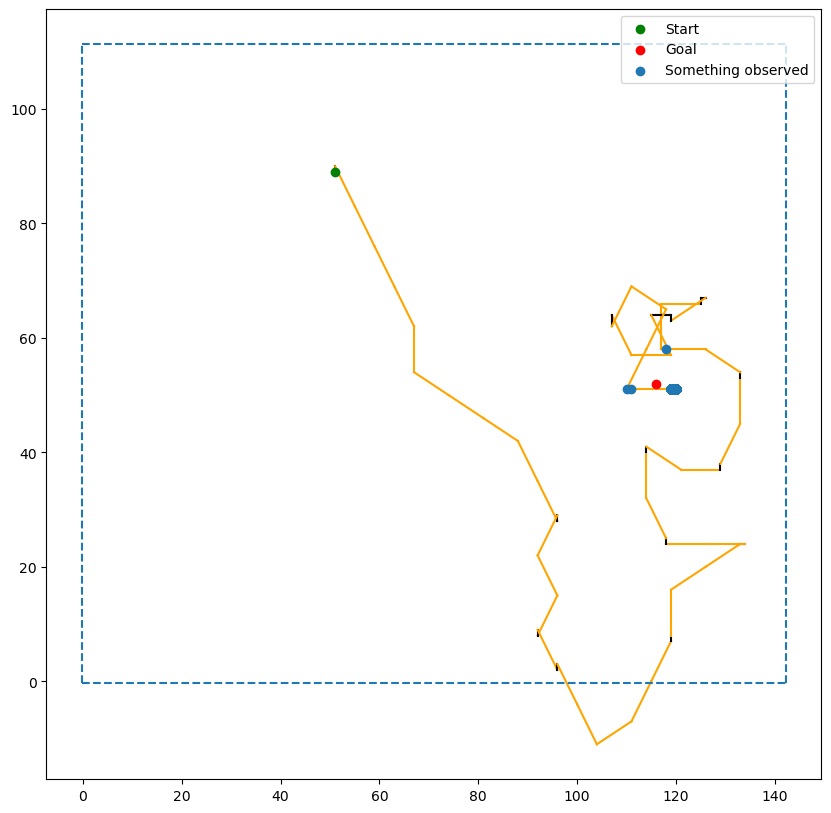

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

# Initial clearing
ax.clear()

# Get cpu model
model = hist.model.cpu_model

# Plot setup
env_shape = model.cpu_model.state_grid.shape
# ax.set_xlim(0, tank_size[1])
# ax.set_ylim(tank_size[0], 0)

# Compute shift
shift = (hist.grid_point_sequence[0] - agent_start)

# Start
start_coord = hist.grid_point_sequence[0] - shift
ax.scatter(start_coord[1], start_coord[0], c='green', label='Start')

# Goal
goal_coord = source_point[None,:]
ax.scatter(goal_coord[:,1], goal_coord[:,0], c='red', label='Goal')

# Until step
seq = np.array(hist.grid_point_sequence) - shift[None,:]
seq_a = (np.array(hist.actions) < 4)

# Path
for i in range(len(seq)-1):
    ax.plot(seq[i:i+2,1], seq[i:i+2,0], c=('black' if seq_a[i] else 'orange'), zorder=-1)#, label=('Walk' if seq_a[i] else 'Swim'))

# ax.plot(seq[:,1], seq[:,0], zorder=-1, c='black', label='Path')

# Something sensed
something_obs_id = model.observation_labels.index('something')
obs_ts = np.where(np.array(hist.observations[:]) == something_obs_id)
points_obs = seq[obs_ts[0],:]
ax.scatter(points_obs[:,1], points_obs[:,0], zorder=1, label='Something observed')

# Generate legend
ax.legend()
ax.hlines([-0.3,tank_size[0]+0.3], xmin=-0.3, xmax=tank_size[1]+0.3, linestyles='dashed')
ax.vlines([-0.3,tank_size[1]+0.3], ymin=-0.3, ymax=tank_size[0]+0.3, linestyles='dashed')

In [34]:
print(f'Walk to swim ratio {np.sum(np.array(hist.actions[:70]) < 4) / 70:.2f}')

Walk to swim ratio 0.39


# Multiple trajectories

In [27]:
# Possible start parameters
source_pos_size = np.array([25,15])
source_pos_margins = np.array([5,5])

agent_start_size = np.array([25,1])
agent_start_margins = np.array([5,44])

# Generation of points
n = 1000

source_point = ((np.random.random((n,2)) * source_pos_size[None,:]) + source_pos_margins[None,:]).astype(int)
agent_start = ((np.random.random((n,2)) * agent_start_size[None,:]) + agent_start_margins[None,:]).astype(int)

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size[None,:] - source_point)

beliefs = []

for center, start in zip(center_state, agent_start_state):
    belief = np.zeros(env_shape)
    belief[center[0]:center[0]+tank_size[0]+1, center[1]:center[1]+tank_size[1]+1] = 1
    belief /= np.sum(belief)

    beliefs.append(belief.flatten())

beliefs = np.array(beliefs)

agent_start_flat = (env_shape[1] * agent_start_state[:,0]) + agent_start_state[:,1]

In [28]:
a = Agent(model=model, value_function=fsvi_solution)

_, hist = a.run_n_simulations_parallel(n=len(agent_start_flat),
                                       start_states=agent_start_flat.tolist(),
                                       initial_beliefs=[Belief(model, b) for b in beliefs])

  0%|          | 0/1000 [00:00<?, ?it/s]

All 1000 simulations done in 30.650s:
	- Simulations reached goal: 944/1000 (56 failures)
	- Average step count: 255.866
	- Average total rewards: 0.944
	- Average discounted rewards (ADR): 0.19446886811015524


In [29]:
# Saving simulation
all_seq = np.empty((len(hist), 1001), dtype=object)
for sim_i, sim in enumerate(hist):
    seq = []
    for s, a, o, r in zip(sim.states, sim.actions+[], sim.observations+[], sim.rewards+[]):
        seq.append(json.dumps({'s':s, 'a':a, 'o':o, 'r':r}))
    
    all_seq[sim_i, :len(seq)] = seq

sim_df = pd.DataFrame(all_seq.T, columns=[f'Sim-{sim_i}' for sim_i in range(len(hist))])

In [30]:
sim_df.to_csv('./sea_robins-sims_walk_swim-edge_start.csv')

# Result analysis

In [ ]:
sim_df = pd.read_csv('./sea_robins-sims-edge_start.csv', index_col=0)

In [31]:
sims = []
for col in sim_df.columns:
    sim_steps = sim_df[col].tolist()
    sim_steps = [json.loads(step) for step in sim_steps if isinstance(step, str)]

    # Creation of simulation history
    sim_hist = SimulationHistory(model, sim_steps[0]['s'], Belief(model))

    sim_hist.states = [step['s'] for step in sim_steps]
    sim_hist.actions = [step['a'] for step in sim_steps]
    sim_hist.observations = [step['o'] for step in sim_steps]
    sim_hist.rewards = [step['r'] for step in sim_steps]

    sims.append(sim_hist)

In [32]:
start_states = np.array([s.states[0] for s in sims]).astype(int)
start_pos = np.array([np.unravel_index(start_states, shape=env_shape)])[0].T

opt_traj = np.sum(np.abs(start_pos - tank_size[None,:]), axis=1)

sim_lengths = np.array([len(s) for s in sims])

In [33]:
y_diff = (start_pos - tank_size[None,:])[:,0]
x_diff = (start_pos - tank_size[None,:])[:,1]

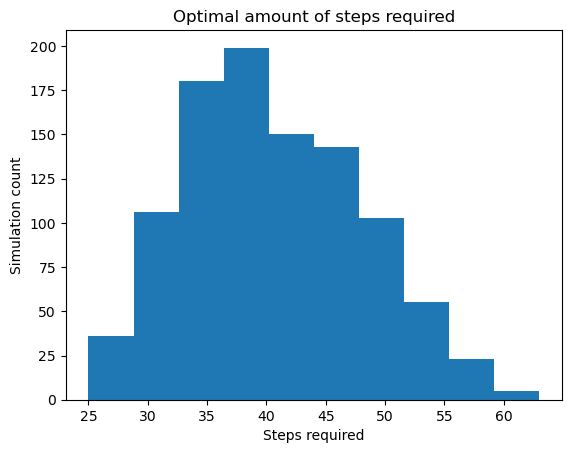

In [34]:
plt.title('Optimal amount of steps required')
plt.hist(opt_traj)
plt.xlabel('Steps required')
plt.ylabel('Simulation count')
plt.show()

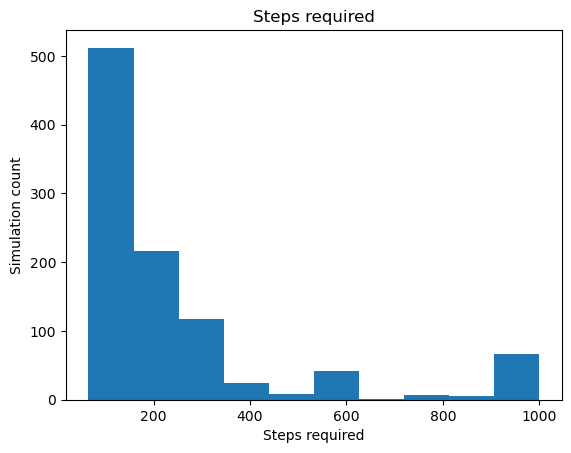

In [35]:
plt.title('Steps required')
plt.hist(sim_lengths)
plt.xlabel('Steps required')
plt.ylabel('Simulation count')
plt.show()

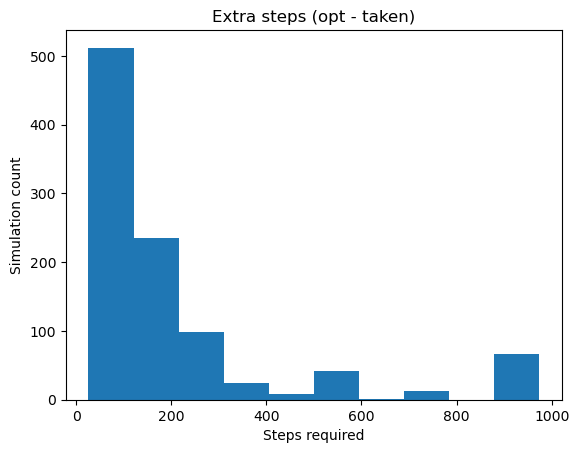

In [36]:
plt.title('Extra steps (opt - taken)')
plt.hist(sim_lengths - opt_traj)
plt.xlabel('Steps required')
plt.ylabel('Simulation count')
plt.show()

Text(0, 0.5, 'Steps taken')

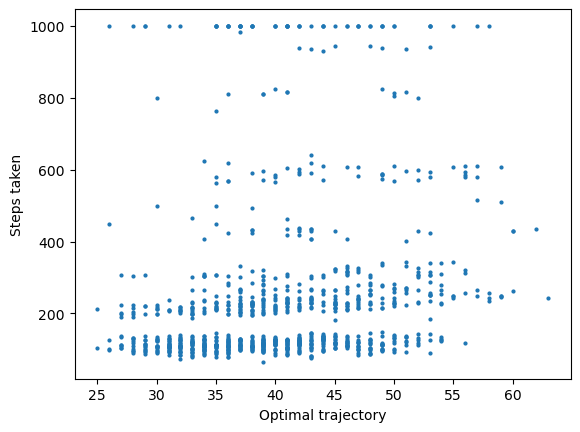

In [37]:
plt.scatter(opt_traj, sim_lengths, s=4)
plt.xlabel('Optimal trajectory')
plt.ylabel('Steps taken')

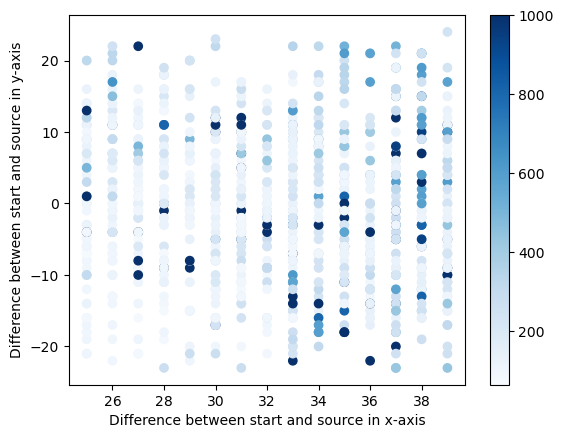

In [38]:
plt.scatter(x=x_diff, y=y_diff, c=sim_lengths, cmap='Blues')
plt.xlabel('Difference between start and source in x-axis')
plt.ylabel('Difference between start and source in y-axis')
plt.colorbar()

Text(0, 0.5, 'Steps taken')

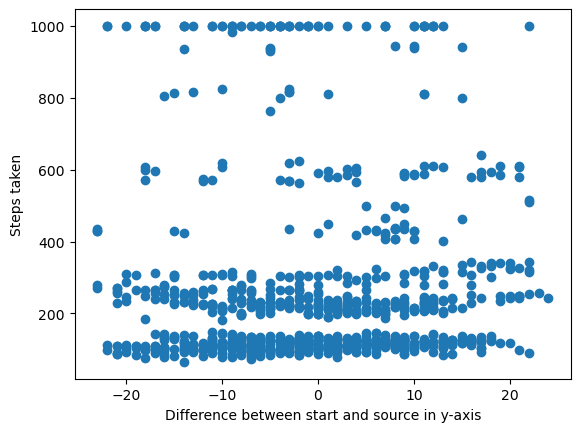

In [39]:
plt.scatter(x=y_diff, y=sim_lengths)
plt.xlabel('Difference between start and source in y-axis')
plt.ylabel('Steps taken')

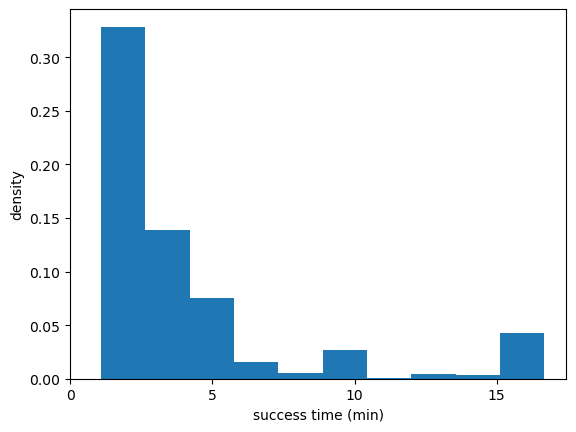

In [41]:
plt.hist((sim_lengths) / 60, density=True)
plt.ylabel('density')
plt.xlabel('success time (min)')
plt.xticks(np.arange(4)*5)
plt.show()

In [42]:
df = pd.DataFrame({'success_time_min': (sim_lengths * 3) / 60})
df.to_csv('./success_times.csv')